# 🏎️ F1 Pre-Race Excitement Forecaster

## 💭 Predictive Task

The goal of our project is to build a binary classification model that predicts whether a Formula 1 race will be **“Exciting”** (1) or **“Not Exciting”** (0) before the race begins.
All predictions must rely solely on pre-race features, such as:

- Qualifying results and grid spread
- Championship standings (point gaps, title contention)
- Circuit characteristics (altitude, layout properties)

The ground-truth labels are generated from post-race data using objective thresholds on:
- Number of DNFs
- Total overtakes

A race is labeled Exciting if it falls in the top 25% in either category.

## Background

Formula 1 is widely regarded as the pinnacle of motorsport, yet the excitement level of each Grand Prix can vary dramatically. Some races unfold as predictable processions, while others deliver unexpected chaos, dramatic overtakes, and major shifts in championship momentum. This inconsistency makes it difficult for casual viewers to decide which races are worth watching, and even dedicated fans often gravitate toward events that promise high action. Predicting that excitement before a race begins, however, is far from straightforward. The dynamics that shape a race’s entertainment value — grid order, competitive pressure, track layout, and environmental conditions — all interact in complex ways that are not immediately obvious.

In recent years, the narrative surrounding a race before it happens has become almost as influential as the race itself. Tight championship battles, surprising qualifying results, unusual track environments, or major penalties can all heighten expectations for an unpredictable event. Although excitement is inherently subjective, many measurable factors correlate with how action-packed a race turns out to be. Metrics such as overtakes, retirements, and field spread provide concrete signals of how dynamic a race was. These relationships motivate our central goal: to build a machine learning classifier capable of predicting a race’s entertainment value *strictly* from ***pre-race information***.

To explore this, we draw on historical Formula 1 data spanning 1950–2024, focusing on features that can be known before lights out — including qualifying performance, driver standings, and circuit characteristics. We then generate an objective “excitement” label using post-race metrics such as DNFs and total overtakes. This allows us to train and evaluate our model without introducing future information into the predictions. By combining pre-race context with well-defined labels, our project investigates whether it is possible to anticipate the entertainment potential of a Grand Prix ahead of time. Such a model can help casual fans choose which races to watch live and may provide broader insight into how pre-race conditions shape the dynamics of Formula 1 competition.

## 🔍 Prior Work

Research on predicting the entertainment value of sporting events has grown a lot in recent years, especially in football, basketball, and various motorsports. Most of that work, however, focuses on performance outcomes — things like predicting the race winner, estimating lap times, or modeling podium finishes. In Formula 1 specifically, there’s been work using historical timing data to estimate pace differences, applying machine learning to forecast pit strategies, or studying how track layout affects overtaking. These kinds of projects show that many aspects of a race can be anticipated using pre-race information.

For Formula 1, several Kaggle notebooks and independent analyses have also looked at how overtakes relate to circuit characteristics, how altitude or temperature impacts power units, and how qualifying gaps influence race-day competitiveness. A lot of these takeaways point toward similar themes: grid variability, championship pressure, and track features all play meaningful roles in shaping how a race plays out — which aligns with the features we build into our model.

What’s much less common is trying to classify the overall “excitement” of a race as its own prediction task. The few attempts that exist usually rely on fan surveys or subjective scoring systems, which can be inconsistent and hard to scale. 

Our approach differs in two important ways:

**Objective Labeling**:
- Instead of using opinions or ratings, we define excitement using measurable post-race metrics like DNFs and overtakes. This gives us a consistent, reproducible label.

**Strictly Pre-Race Features**:
- We only use information available before the race starts, which helps avoid data leakage — something not all prior work accounts for.

By combining insights from motorsport analytics with this stricter setup, our project pushes into a relatively under-explored space: trying to predict how entertaining a Formula 1 race will be before anyone has turned a wheel.

## 📊 Data

#### Dataset #1 — Formula 1 World Championship Dataset

Dataset Name: [Formula 1 World Championship (1950–2024)](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)

Number of observations: ~80,000+ records across all tables

Number of variables: Varies by table (5–20 columns each)

This dataset contains the official historical results from every Formula 1 race, including tables such as races, results, qualifying, driver_standings, circuits, and lap_times. Important variables include race metadata (year, round, circuit), driver finishing positions, qualifying times, lap-by-lap positions, and driver point standings. These variables represent concrete performance and contextual indicators such as competitiveness, grid spread, pace variability, and circuit characteristics. For preprocessing, we filtered the data to modern-era races (year ≥ 2000), handled null values, merged weather data, and removed irrelevant scheduling columns before feature engineering and label creation.

#### Dataset #2 — Formula 1 Weather Dataset

Dataset Name: [Formula 1 Race Weather Info (1950–2024)](https://www.kaggle.com/datasets/mariyakostyrya/formula-1-weather-info-1950-2024)

Number of observations: ~1,500

Number of variables: 10

This dataset provides race-day weather conditions such as temperature, precipitation, humidity, and wind speed for each Grand Prix. Key variables we use include temperature (float), precipitation (float), and a derived feature is_rain, which captures whether the track was wet. Weather serves as a proxy for external race conditions that can influence excitement, risk-taking, and chaos (e.g., wet races tend to produce more DNFs and overtakes). Preprocessing steps included converting timestamps into year/round identifiers, filling missing values with reasonable defaults, and merging the data into the main race table.

#### Dataset #3 — Combined Race-Level Dataset (Engineered)

Dataset Name: F1 Race-Level Modeling Dataset (Engineered)

Link: Locally created from dataset #1 and #2

Number of observations: 400–450 races (depending on filtering)

Number of variables: ~20 engineered features

This final dataset is constructed by merging the cleaned race metadata with pre-race features (qualifying spread, grid shake-ups, championship tension) and the weather variables. Additional post-race metrics from results and lap_times are used only to create the ground-truth excitement labels (DNFs → chaos score, position changes → action score). Preprocessing involved merging multiple CSVs on raceId, calculating new features, filtering to modern seasons, and ensuring no data leakage by keeping all post-race information strictly for label generation.

In [1]:
# --- Imports & Configuration ---
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
DATA_PATH = 'data/'  # Folder where you unzipped the Kaggle dataset
START_YEAR = 2000    # We focus on the modern era for data consistency

In [2]:
# --- Data Loading ---
def load_data():
    print("Loading Vopani Dataset CSVs...")
    # Load core files with '\N' handling for nulls
    races = pd.read_csv(f'{DATA_PATH}races.csv', na_values='\\N')
    results = pd.read_csv(f'{DATA_PATH}results.csv', na_values='\\N')
    status = pd.read_csv(f'{DATA_PATH}status.csv', na_values='\\N')
    qualifying = pd.read_csv(f'{DATA_PATH}qualifying.csv', na_values='\\N')
    standings = pd.read_csv(f'{DATA_PATH}driver_standings.csv', na_values='\\N')
    circuits = pd.read_csv(f'{DATA_PATH}circuits.csv', na_values='\\N')
    lap_times = pd.read_csv(f'{DATA_PATH}lap_times.csv', na_values='\\N')
    weather = pd.read_csv(f'{DATA_PATH}weather.csv', na_values='\\N')
    print("Datasets are loaded in...")

    return races, results, status, qualifying, standings, circuits, lap_times, weather

# Load the raw dataframes
races_df, results_df, status_df, qual_df, stand_df, circuits_df, laps_df, weather_df = load_data()

Loading Vopani Dataset CSVs...
Datasets are loaded in...


In [3]:
# --- Cleaning & Weather Merging ---
def clean_and_merge_weather(races, weather):
    print("Processing & Merging Weather Data...")
    
    # 1. Extract Year from Weather Date
    weather['datetime'] = pd.to_datetime(weather['datetime'])
    weather['year'] = weather['datetime'].dt.year
    
    # 2. Create "Is Rain" Feature
    # Logic: If precipitation > 0.0, the track is wet.
    weather['is_rain'] = (weather['precipitation'] > 0).astype(int)

    # 3. Merge Weather with Official Race List
    # We join on ['year', 'round'] to align the weather with the correct Race ID
    merged_races = pd.merge(
        races, 
        weather[['year', 'round', 'temperature', 'precipitation', 'is_rain']], 
        on=['year', 'round'], 
        how='left'
    )
    
    # 4. Filter for Modern Era (2000+)
    # merged_races = merged_races[merged_races['year'] >= START_YEAR].copy()
    
    # 5. Handle Missing Weather (Missing)
    # We fill with defaults (Dry, 20°C) so the model doesn't crash
    merged_races['precipitation'] = merged_races['precipitation'].fillna(0)
    merged_races['temperature'] = merged_races['temperature'].fillna(20.0)
    merged_races['is_rain'] = merged_races['is_rain'].fillna(0).astype(int)

    drop_cols = [
        'url', 
        'fp1_date', 'fp1_time', 
        'fp2_date', 'fp2_time', 
        'fp3_date', 'fp3_time', 
        'quali_date', 'quali_time', 
        'sprint_date', 'sprint_time'
    ]
    
    # Only drop columns that actually exist in the dataframe to avoid errors
    cols_to_drop = [c for c in drop_cols if c in merged_races.columns]
    
    df_clean = merged_races.drop(columns=cols_to_drop)
    
    print(f"Total Races processed: {merged_races.shape[0]}")
    return df_clean

# Execute Cleaning
main_races = clean_and_merge_weather(races_df, weather_df)
# Apply the cleaning

# Verify what's left
print("Columns kept:", main_races.columns.tolist())
main_races.head()

Processing & Merging Weather Data...
Total Races processed: 1125
Columns kept: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'temperature', 'precipitation', 'is_rain']


,raceId,year,round,circuitId,name,date,time,temperature,precipitation,is_rain
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,23.0,0.0,0
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,26.4,4.2,1
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,19.2,0.9,1
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,30.1,0.0,0
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,21.3,0.0,0


In [4]:
# --- Generating Labels (Y) ---
def generate_labels(races, results, status, laps):
    print("Calculating Excitement Labels...")
    
    # counts of unique race id
    target_race_ids = races['raceId'].unique()
    
    # --- A. Calculate CHAOS Score (DNFs) ---
    # Chaos is a metric determined by how drivers finished a race out of the participating drivers
    # The drivers that finished a race, the more likely that the chaos score is lowered

    # Copy from results df to get filtered unique race ids
    results_filtered = results[results['raceId'].isin(target_race_ids)].copy()
    
    # Status IDs 1, 11-19 represent normal finishes. Everything else is a DNF.
    # In status.csv, ids 1 is considered a normal finish, ids 11-19 refer to how many laps the leader lapped this driver
    # The # of laps that the driver was lapped is id - 10 (e.g 11-10 = +1 laps)
    # We will consider all types of finishes as a safe finish
    normal_finish_ids = [1] + list(range(11, 20))

    # Create a new dataframe column name 'is_dnf' 
    # Checks if drivers in results_filtered had a normal finish
    # If true, the tilde inverts (NOT operator) to false and vice versa
    results_filtered['is_dnf'] = ~results_filtered['statusId'].isin(normal_finish_ids)
    
    # Group results_filtered by the race and sum everything in the 'is_dnf' column
    # Rename the column of the resulting dataframe into a chaos score
    chaos_df = results_filtered.groupby('raceId')['is_dnf'].sum().reset_index()
    chaos_df.rename(columns={'is_dnf': 'chaos_score'}, inplace=True)
    
    # --- B. Calculate ACTION Score (Overtakes/Position Changes) ---
    # Filter laps from laptimes.csv with each unique race ids.
    laps_filtered = laps[laps['raceId'].isin(target_race_ids)].copy()
    laps_filtered.sort_values(['raceId', 'driverId', 'lap'], inplace=True)
    
    # Calculate position change from previous lap
    # Sort by race, driver, and position
    # This line takes a unique driver's position in between laps
    # diff() computes the difference of current row to previous row
    laps_filtered['pos_change'] = laps_filtered.groupby(['raceId', 'driverId'])['position'].diff().abs()

    # Group results by new 'pos_change' column to include only the race and position and sum on the position values
    # High values mean more position changes = suggests more action
    # Low values mean steady position placement = suggest "boring" race
    action_df = laps_filtered.groupby('raceId')['pos_change'].sum().reset_index()
    action_df.rename(columns={'pos_change': 'action_score'}, inplace=True)
    
    # --- C. Create Final Label ---
    # Merge the previous metrics given each unique race
    metrics = races[['raceId']].merge(chaos_df, on='raceId', how='left')
    metrics = metrics.merge(action_df, on='raceId', how='left').fillna(0)
    
    # Define "Exciting" as Top 25% in Chaos OR Top 25% in Action
    chaos_thresh = metrics['chaos_score'].quantile(0.75)
    action_thresh = metrics['action_score'].quantile(0.75)
    
    metrics['is_exciting'] = (
        (metrics['chaos_score'] > chaos_thresh) | 
        (metrics['action_score'] > action_thresh)
    ).astype(int)
    
    print(f"Thresholds -> Chaos: >{chaos_thresh} DNFs, Action: >{action_thresh} Changes")
    return metrics[['raceId', 'is_exciting']]

# Execute Label Generation
labels_df = generate_labels(main_races, results_df, status_df, laps_df)
print(labels_df)

Calculating Excitement Labels...
Thresholds -> Chaos: >15.0 DNFs, Action: >277.0 Changes
      raceId  is_exciting
0          1            1
1          2            1
2          3            1
3          4            1
4          5            0
...      ...          ...
1120    1140            0
1121    1141            0
1122    1142            1
1123    1143            0
1124    1144            0

[1125 rows x 2 columns]


## EDA

In [5]:
def convert_laptime(x):
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):  # already numeric
        return x
    m, s = x.split(':')
    return float(m)*60 + float(s)

def clean_laptime(t):
    if pd.isna(t):
        return np.nan
    if t < 30 or t > 600:   # unrealistic for any F1 circuit in any era
        return np.nan
    return t

for col in ['q1','q2','q3']:
    qual_df[col] = qual_df[col].apply(convert_laptime)
    qual_df[col] = qual_df[col].apply(clean_laptime)

Merge qualifying lap times with year to allow for the computation of future features

In [6]:
qual_df = qual_df.merge(
    races_df[['raceId', 'year', 'round']],
    on='raceId',
    how='left'
)

qual_df['best_time'] = qual_df[['q3', 'q2', 'q1']].bfill(axis=1).iloc[:, 0]

#### Grid Spread
Grid spread measures how mixed or tight the starting grid is.
We compute it as the standard deviation of the qualifying positions for a race:
- Low grid spread → the grid is tightly packed (fast cars at the front, slow cars at the back).
- High grid spread → the grid is more scattered (drivers “out of order” relative to usual performance)

Races with larger grid spread values are typically more chaotic, because faster cars have to recover from deeper in the pack. This doesn’t guarantee an exciting race on its own, but it provides reliable contextual information.

In [7]:
# ---------- GRID SPREAD ----------
grid_spread_time = (
    qual_df.groupby("raceId")["best_time"]
    .std()
    .reset_index()
    .rename(columns={"best_time": "grid_spread_time"})
)

grid_spread_time.describe()

,raceId,grid_spread_time
count,494.000000,493.000000
mean,633.838057,1.746025
std,432.494962,1.599360
min,1.000000,0.452559
25%,128.750000,0.931818
50%,879.500000,1.305608
75%,1013.750000,1.870005
max,1144.000000,13.740381


#### Grid shake-up
Grid shake-up measures how far drivers qualified from their usual season performance. Bigger shake-up means the grid is more unusual. These out-of-position starts typically lead to more overtakes and more unpredictable race behavior, making it a subtle but meaningful predictor of excitement.

In [8]:

# ---------- GRID SHAKE-UP ----------
# seasonal qualifying average per driver
season_avg = (
    qual_df.groupby(['year', 'driverId'])['position']
    .mean()
    .reset_index()
    .rename(columns={'position': 'season_avg_position'})
)

qual_pos = qual_df.merge(season_avg, on=["year", "driverId"], how="left")
qual_pos["shake"] = (qual_pos["position"] - qual_pos["season_avg_position"]).abs()

grid_shakeup = (
    qual_pos.groupby("raceId")["shake"]
    .mean()
    .reset_index()
    .rename(columns={"shake": "grid_shakeup"})
)

grid_shakeup.describe()

,raceId,grid_shakeup
count,494.000000,494.000000
mean,633.838057,2.408847
std,432.494962,0.719960
min,1.000000,0.000000
25%,128.750000,1.916332
50%,879.500000,2.336714
75%,1013.750000,2.801939
max,1144.000000,5.677114


#### Title Tension
Title tension summarizes how close the championship fight is. While it mainly captures fan hype rather than hard race dynamics, close title battles can increase driver aggression and strategic risk, making it a useful context feature even if the direct correlation with our label is small.

In [9]:
# ---------- TITLE TENSION ----------
title_tension = (
    stand_df.groupby("raceId")
    .apply(lambda df: df.sort_values("points", ascending=False).head(3)["points"].std())
    .reset_index(name="title_tension")
)

title_tension.describe()

C:\Users\sword\AppData\Local\Temp\ipykernel_16684\2207723089.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("points", ascending=False).head(3)["points"].std())


,raceId,title_tension
count,1125.000000,1125.000000
mean,565.710222,17.505845
std,328.813817,20.731180
min,1.000000,0.000000
25%,282.000000,4.618802
50%,563.000000,10.440307
75%,845.000000,21.385353
max,1144.000000,183.930240


#### Altitude
Altitude is a track-level feature that affects engine power, cooling, and drag. Certain high-altitude tracks tend to produce more mechanical issues or unusual pace differences. This makes altitude a small but potentially relevant contextual factor, even though its direct correlation with excitement is mild.

In [10]:
# ---------- ALTITUDE ----------
altitude = circuits_df[["circuitId", "alt"]].rename(columns={"alt": "altitude"})

Our pre-race features reflect different aspects of the race weekend: grid spread measures how mixed the starting order is; grid shake-up captures how unusual drivers’ qualifying results are relative to their season; title tension describes the competitive pressure in the championship; and altitude represents circuit-specific environmental difficulty. While none of these features individually guarantee an exciting race, each provides contextual cues that, when combined, contribute meaningful predictive signal.

In [12]:
# ---------- MERGE EVERYTHING ----------
eda_df = (
    main_races
    .merge(labels_df, on="raceId", how="left")
    .merge(grid_spread_time, on="raceId", how="left")
    .merge(grid_shakeup, on="raceId", how="left")
    .merge(title_tension, on="raceId", how="left")
    .merge(altitude, on="circuitId", how="left")
)

eda_df.head()

,raceId,year,round,circuitId,name,date,time,temperature,precipitation,is_rain,is_exciting,grid_spread_time,grid_shakeup,title_tension,altitude
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,23.0,0.0,0,1,0.557599,2.772451,2.000000,10
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,26.4,4.2,1,1,0.646675,2.919706,3.403430,18
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,19.2,0.9,1,1,0.928870,2.667549,5.507571,5
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,30.1,0.0,0,1,0.576017,2.772451,7.234178,7
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,21.3,0.0,0,0,0.643661,2.946176,9.451631,109


In [13]:
eda_df.isna().sum()

raceId                0
year                  0
round                 0
circuitId             0
name                  0
date                  0
time                731
temperature           0
precipitation         0
is_rain               0
is_exciting           0
grid_spread_time    632
grid_shakeup        631
title_tension         0
altitude              0
dtype: int64

In [14]:
eda_df.dropna(inplace=True)

In [16]:
features = [
    "grid_spread_time", "grid_shakeup", "title_tension",
    "altitude", "temperature", "precipitation", "is_rain"
]

#demonstrates correlation between data and how exciting the race is
eda_df[features + ["is_exciting"]].corr()["is_exciting"]

grid_spread_time    0.027568
grid_shakeup       -0.047985
title_tension       0.121237
altitude            0.010532
temperature         0.005394
precipitation       0.084681
is_rain             0.075636
is_exciting         1.000000
Name: is_exciting, dtype: float64

In [17]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=eda_df, x="grid_spread", hue="is_exciting", fill=True, common_norm=False)
plt.title("Distribution of Grid Spread for Exciting vs Non-Exciting Races")
plt.xlabel("Grid Spread (Std Dev of Qualifying Positions)")
plt.show()

ValueError: Could not interpret value `grid_spread` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

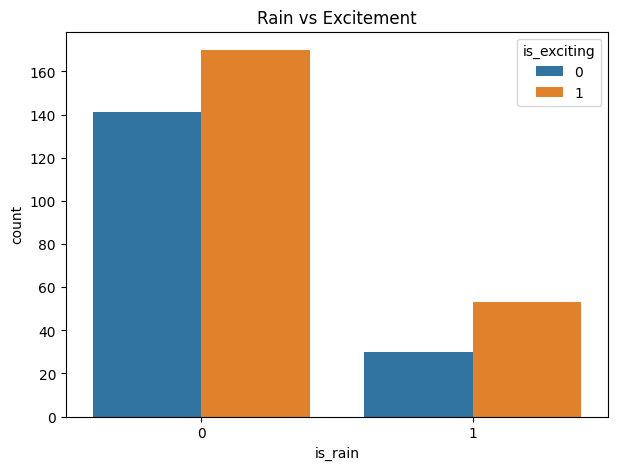

In [18]:
plt.figure(figsize=(7,5))
sns.countplot(data=eda_df, x="is_rain", hue="is_exciting")
plt.title("Rain vs Excitement")
plt.show()

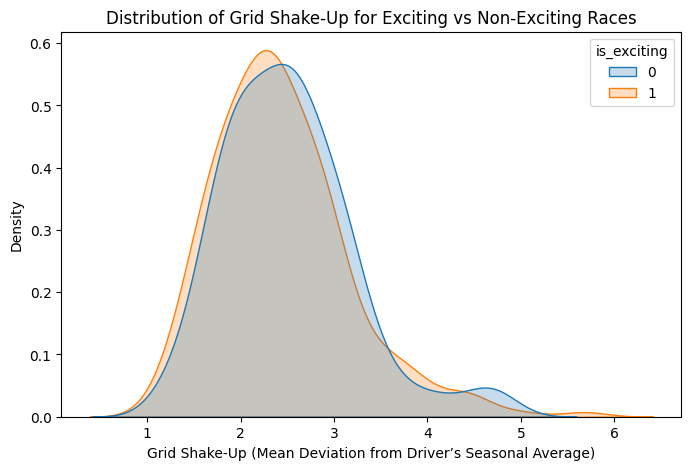

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=eda_df, x="grid_shakeup", hue="is_exciting", fill=True, common_norm=False)
plt.title("Distribution of Grid Shake-Up for Exciting vs Non-Exciting Races")
plt.xlabel("Grid Shake-Up (Mean Deviation from Driver’s Seasonal Average)")
plt.show()

#### Grid Shake-Up vs. Race Excitement
Grid shake-up measures how unusual the starting grid is compared to each driver’s typical qualifying performance that season. Higher shake-up values mean more drivers are starting far from where they “normally” qualify (e.g., a top driver starting P12, or a midfield driver unexpectedly lining up P5).

The KDE plot below compares the distribution of shake-up between exciting and non-exciting races:

- Both groups peak around 2.0–2.5, meaning most races involve some moderate amount of qualifying variability.

- The curve for exciting races is slightly shifted to the right, showing more density between 2.5–4.0.

- This suggests that exciting races tend to have a bit more qualifying chaos — cars starting out of position, which naturally leads to more overtaking and more dynamic race scenarios.

Even though the difference between the two distributions is subtle, it aligns with Formula 1 intuition: When the grid is mixed up, the race is usually more eventful. However, the heavy overlap also makes it clear that qualifying shake-up is not the sole source of excitement — many unpredictable factors on race day (weather, crashes, safety cars, tyre issues) can overshadow what happens on Saturday.

Exciting races show a slightly higher grid shake-up distribution, meaning more drivers start out of position compared to their seasonal average — a factor that tends to lead to more overtakes and race variability.

In [20]:
# Scale train and test
def scaleDatasets(train_df, test_df):
    scaler = StandardScaler()

    # Fit only on training data
    scaler.fit(train_df)

    # Transform both
    train_scaled = scaler.transform(train_df)
    test_scaled = scaler.transform(test_df)

    return train_scaled, test_scaled, scaler


In [21]:
#Drop features we don't need from the dataframe and split it into training and test sets
#also drop the is_exciting stat from the test datframe
def dfSplit(eda_df, features):
    feature_df = eda_df[features + ["is_exciting"]]
    size = len(feature_df)

    feature_df = feature_df.sample(frac = 1, random_state = 0)
    train_df = feature_df.iloc[:int(size * 0.8)]
    train_labels = train_df.pop("is_exciting")
    test_df = feature_df.iloc[int(size * 0.8):]
    test_labels = test_df.pop("is_exciting")

    return train_df, train_labels, test_df, test_labels

train_df, train_labels, test_df, test_labels = dfSplit(eda_df, features)
train_df, test_df, scaler = scaleDatasets(train_df, test_df)

In [22]:
new_train_df = pd.DataFrame(train_df, columns=features)
new_train_df.describe()

,grid_spread_time,grid_shakeup,title_tension,altitude,temperature,precipitation,is_rain
count,3.150000e+02,3.150000e+02,3.150000e+02,3.150000e+02,3.150000e+02,3.150000e+02,3.150000e+02
mean,-1.860945e-16,-6.569701e-16,-1.353415e-16,-2.819614e-18,-1.297022e-16,1.127846e-17,-1.409807e-17
std,1.001591e+00,1.001591e+00,1.001591e+00,1.001591e+00,1.001591e+00,1.001591e+00,1.001591e+00
min,-8.070713e-01,-1.778347e+00,-1.124670e+00,-5.601524e-01,-3.001184e+00,-3.059735e-01,-5.296110e-01
25%,-5.246929e-01,-7.462808e-01,-7.474115e-01,-5.205456e-01,-7.217419e-01,-3.059735e-01,-5.296110e-01
50%,-2.725569e-01,-1.334861e-01,-2.801369e-01,-4.130416e-01,-2.998837e-03,-3.059735e-01,-5.296110e-01
75%,1.298894e-01,5.482154e-01,4.942025e-01,-8.204252e-02,7.362798e-01,-3.059735e-01,-5.296110e-01
max,6.384622e+00,3.677952e+00,5.609961e+00,5.759950e+00,2.871974e+00,9.129994e+00,1.888178e+00


In [23]:
train_df, train_labels

(array([[-0.18814429, -0.75962814,  0.16952572, ..., -0.18781849,
         -0.30597354, -0.52961099],
        [ 0.34010559, -0.13373464,  0.87714394, ..., -0.63959988,
         -0.08130765,  1.88817833],
        [-0.24346215,  0.1787197 , -0.03110842, ..., -1.39941402,
         -0.30597354, -0.52961099],
        ...,
        [ 3.5443444 , -0.7621477 , -0.86489993, ...,  1.1059191 ,
          0.36802412,  1.88817833],
        [ 0.09174051, -0.71778955,  0.1762417 , ...,  1.00324152,
         -0.30597354, -0.52961099],
        [-0.16175662, -1.35917605,  0.32444508, ..., -0.39317367,
         -0.30597354, -0.52961099]], shape=(315, 7)),
 844     1
 1012    0
 68      1
 886     1
 1060    0
        ..
 1010    1
 958     0
 879     1
 874     0
 911     1
 Name: is_exciting, Length: 315, dtype: int64)

In [24]:
def train_model(X_train, y_train):
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train, y_train)

    return model

logisticModel = train_model(train_df, train_labels)

In [ ]:
def test_logistic_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    #print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

test_logistic_model(logisticModel, train_df, train_labels)  

Accuracy: 0.5777777777777777
              precision    recall  f1-score   support

           0       0.52      0.09      0.15       134
           1       0.58      0.94      0.72       181

    accuracy                           0.58       315
   macro avg       0.55      0.51      0.44       315
weighted avg       0.56      0.58      0.48       315

